<a href="https://colab.research.google.com/github/MahaleVivek/HandsOn-LLMs/blob/modules/modules/Ch11_Finetuning_representation_models_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Supervised Classification

In [ ]:
### Fine-Tuning a Pretrained BERT Model

In [4]:
!pip install datasets -q

In [5]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
#We define the number of labels that we want to predict beforehand. This is necessary to
# create the feedforward neural network that is applied on top of our pretrained model:

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# Tokenize our data

In [ ]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8530
})

In [ ]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [ ]:
tokenized_test

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1066
})

In [ ]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})

In [ ]:
train_data[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [ ]:
tokenized_train[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1,
 'input_ids': [101,
  1103,
  2067,
  1110,
  17348,
  1106,
  1129,
  1103,
  6880,
  1432,
  112,
  188,
  1207,
  107,
  14255,
  1389,
  107,
  1105,
  1115,
  1119,
  112,
  188,
  1280,
  1106,
  1294,
  170,
  24194,
  1256,
  3407,
  1190,
  170,
  11791,
  5253,
  188,
  1732,
  7200,
  10947,
  12606,
  2895,
  117,
  179,
  7766,
  118,
  172,
  15554,
  1181,
  3498,
  6961,
  3263,
  1137,
  188,
  1566,
  7912,
  14516,
  6997,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  

#### Before creating the Trainer, we will want to prepare a special DataCollator.
> A DataCollator is a class that helps us build batches of data but also allows us to apply data augmentation.

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
   """Calculate F1 score"""
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   load_f1 = evaluate.load("accuracy")
   f1 = load_f1.compute(predictions=predictions, references=labels)["accuracy"]
   return {"accuracy": f1}

#### With compute_metrics we can define any number of metrics that we are interested in and that can be printed out or logged during training. This is especially helpful during training as it allows for detecting overfitting behavior.

In [ ]:
# Instantiate Trainer

from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

In [ ]:
# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-24-2157897e7954>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# The TrainingArguments class defines hyperparameters we want to tune, such as the
# learning rate and how many epochs (rounds) we want to train. The Trainer is used to execute the training process.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7012843489646912,
 'eval_model_preparation_time': 0.0166,
 'eval_accuracy': 0.49906191369606,
 'eval_runtime': 3.8489,
 'eval_samples_per_second': 276.959,
 'eval_steps_per_second': 17.407}

### Freezing Layers

To further showcase the importance of training the entire network, the next example will demonstrate how you can use Hugging Face Transformers to freeze certain layers of your network.

We will freeze the main BERT model and allow only updates to pass through the classification head. This will be a great comparison as we will keep everything the same, except for freezing specific layers.



In [ ]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

Our pretrained BERT model contains a lot of layers that we can potentially freeze. Inspecting these layers gives insight into the structure of the network and what we might want to freeze:

We could choose to only freeze certain layers to speed up computing but still allow the main model to learn from the classification task. Generally, we want frozen layers to be followed by trainable layers.

We are going to freeze everything except for the classification head

In [ ]:
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

we have frozen everything except for the feedforward neural network, which is our classification head.

In [ ]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-30-1da7f8eeebcf>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.685500


TrainOutput(global_step=534, training_loss=0.6852787496445331, metrics={'train_runtime': 40.3793, 'train_samples_per_second': 211.247, 'train_steps_per_second': 13.225, 'total_flos': 227605451772240.0, 'train_loss': 0.6852787496445331, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6766408085823059,
 'eval_accuracy': 0.5984990619136961,
 'eval_runtime': 3.9844,
 'eval_samples_per_second': 267.547,
 'eval_steps_per_second': 16.816,
 'epoch': 1.0}

In [ ]:
# When we evaluate the model, we only get an accuracy score of 0.59, Instead of
# freezing nearly all layers, let’s freeze everything up until encoder block 10
# and see how it affects performance. A major benefit is that this reduces
# computation but still allows updates to flow through part of the pretrained model:

In [ ]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 11 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-33-742930ef214b>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
500,0.476100


TrainOutput(global_step=534, training_loss=0.4725381408291363, metrics={'train_runtime': 44.1194, 'train_samples_per_second': 193.339, 'train_steps_per_second': 12.104, 'total_flos': 227605451772240.0, 'train_loss': 0.4725381408291363, 'epoch': 1.0})

In [ ]:
# evaluate the result
trainer.evaluate()

{'eval_loss': 0.4100644588470459,
 'eval_accuracy': 0.8105065666041276,
 'eval_runtime': 3.545,
 'eval_samples_per_second': 300.701,
 'eval_steps_per_second': 18.9,
 'epoch': 1.0}

We got an Accuracy score of 0.81, which is much higher than our previous score of 0.59 when freezing all layers. It demonstrates that although we generally want to train as many layers as possible, you can get away with training less if you do not have the necessary computing power.



---



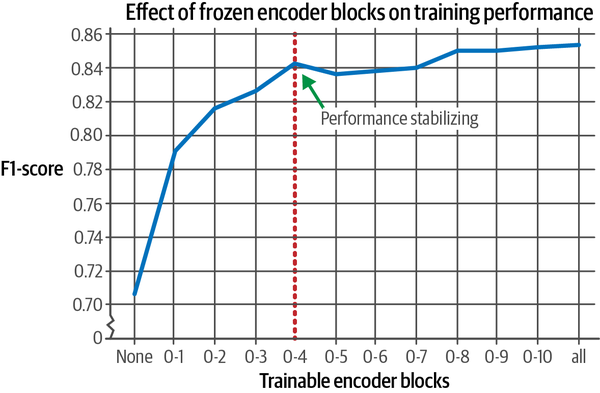

To further illustrate this effect, we tested the effect of iteratively freezing encoder blocks and fine-tuning them as we did thus far. training only the first five encoder blocks (red vertical line) is enough to almost reach the performance of training all encoder blocks.

Note:
When you are training for multiple epochs, the difference (in training time and resources) between freezing and not freezing often becomes larger. It is therefore advised to play around with a balance that works for you.

### Few-Shot Classification

##### Fine tuning for Few shot classification

We previously trained on a dataset containing roughly 8,500 movie reviews. However, since this is a few-shot setting, we will only sample 16 examples per class. With two classes, we will only have 32 documents to train on compared to the 8,500 movie reviews we used before!

In [2]:
!pip install setfit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
from setfit import sample_dataset

# We simulate a few-shot setting by sampling 16 examples per class
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [7]:
from setfit import SetFitModel

# Load a pretrained SentenceTransformer model
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [8]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# Define training arguments
args = SetFitTrainingArguments(
    num_epochs=3, # The number of epochs to use for contrastive learning
    num_iterations=20  # The number of text pairs to generate
)
args.eval_strategy = args.evaluation_strategy

In [10]:
# After loading in the pretrained SentenceTransformer model, we can start defining
# our SetFitTrainer. By default, a logistic regression model is chosen as the classifier to train.

In [9]:
# Create trainer
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [11]:
# Training loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vivekmahale9853 (vivekmahale9853-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


When we do not specifically define a classification head, by default a logistic regression is used. If we would like to specify a classification head ourselves, we can do so by specifying the following model in SetFitTrainer:

```
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2",
    use_differentiable_head=True,
    head_params={"out_features": num_classes},
)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    ...
)
```

Here, num_classes refers to the number of classes that we want to predict.

In [12]:
# Evaluate the model on our test data
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.845703125}

With only 32 labeled documents, we get an F1 score of 0.84. Considering that the model was trained on a tiny subset of the original data, this is very impressive!



---



TIP: Not only can SetFit perform few-shot classification tasks, but it also has support for when you have no labels at all, also called zero-shot classification. SetFit generates synthetic examples from the label names to resemble the classification task and then trains a SetFit model on them. For example, if the target labels are “happy” and “sad,” then synthetic data could be “The example is happy” and “This example is sad.”

### Continued Pretraining with Masked Language Modeling

This two-step approach is typically used throughout many applications. It has its limitations when faced with domain-specific data. The pretrained model is often trained on very general data, like Wikipedia pages, and might not be tuned to your domain-specific words.

Instead of adopting this two-step approach, we can squeeze another step between them, namely continue pretraining an already pretrained BERT model. In other words, we can simply continue training the BERT model using masked language modeling (MLM) but instead use data from our domain. It is like going from a general BERT model to a BioBERT model specialized for the medical domain, to a fine-tuned BioBERT model to classify medication.

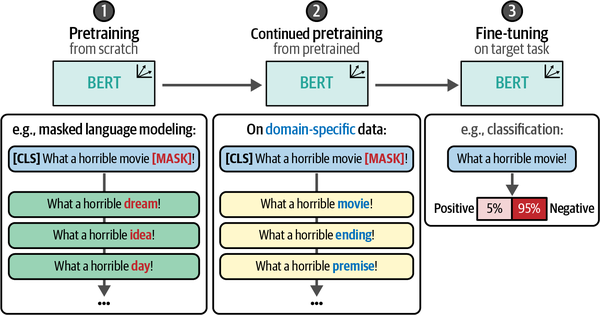

In [13]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model for masked language modeling (MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [14]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Tokenize data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Previously, we used DataCollatorWithPadding, which dynamically pads the input it receives.

Instead, we will have a DataCollator that will perform the masking of tokens for us. There are two methods that are generally used for this: token and whole-word masking. With token masking, we randomly mask 15% of the tokens in a sentence. It might happen that part of a word will be masked. To enable masking of the entire word, we could apply whole-word masking

In [17]:
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer

# Masking Tokens
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [18]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

In [19]:
# we will create the Trainer for running the MLM task and specify certain parameters:

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-19-877e1d0238ca>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# Save pre-trained tokenizer
tokenizer.save_pretrained("mlm")

# Train model
trainer.train()

# Save updated model
model.save_pretrained("mlm")

Step,Training Loss
500,2.604200
1000,2.371300
1500,2.306600
2000,2.190800
2500,2.149400
3000,2.089100
3500,2.053200
4000,1.993300
4500,1.986600
5000,1.955400


In [22]:
#We will do so by loading in our pretrained model before we continue pretraining.
# Using the sentence "What a horrible [MASK]!" the model will predict which word would be in place of "[MASK]":

from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> {'score': 0.05696643888950348, 'token': 1911, 'token_str': 'idea', 'sequence': 'What a horrible idea!'}
>>> {'score': 0.05556366220116615, 'token': 4185, 'token_str': 'dream', 'sequence': 'What a horrible dream!'}
>>> {'score': 0.05524478852748871, 'token': 1645, 'token_str': 'thing', 'sequence': 'What a horrible thing!'}
>>> {'score': 0.04608907178044319, 'token': 1285, 'token_str': 'day', 'sequence': 'What a horrible day!'}
>>> {'score': 0.03224373608827591, 'token': 1354, 'token_str': 'thought', 'sequence': 'What a horrible thought!'}


In [24]:
# Print results
for pred in preds:
    print(">>>", pred["sequence"])

>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


The output demonstrates concepts like “idea,” “dream,” and “day,” which definitely make sense. Next, let’s see what our updated model predicts:

In [26]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred}")

Device set to use cuda:0


>>> {'score': 0.573688805103302, 'token': 2523, 'token_str': 'movie', 'sequence': 'What a horrible movie!'}
>>> {'score': 0.14788870513439178, 'token': 1273, 'token_str': 'film', 'sequence': 'What a horrible film!'}
>>> {'score': 0.07012327015399933, 'token': 6477, 'token_str': 'mess', 'sequence': 'What a horrible mess!'}
>>> {'score': 0.016127781942486763, 'token': 3789, 'token_str': 'comedy', 'sequence': 'What a horrible comedy!'}
>>> {'score': 0.011982053518295288, 'token': 1642, 'token_str': 'story', 'sequence': 'What a horrible story!'}


In [27]:
# Print results
for pred in preds:
    print(">>>", pred["sequence"])

>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!


A horrible movie, film, mess, etc. clearly shows us that the model is more biased toward the data that we fed it compared to the pretrained model.



---

The next step would be to fine-tune this model on the classification task that we did at the beginning of this chapter. Simply load the model as follows and you are good to go:

In [28]:
from transformers import AutoModelForSequenceClassification

# Fine-tune for classification
model = AutoModelForSequenceClassification.from_pretrained("mlm", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("mlm")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Named-Entity Recognition

Preparing Data for Named-Entity Recognition


>In this example, we will use the English version of the CoNLL-2003 dataset, which contains several different types of named entities (person, organization, location, miscellaneous, and no entity) and has roughly 14,000 training samples.

In [29]:
# The CoNLL-2003 dataset for NER
dataset = load_dataset("conll2003", trust_remote_code=True)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [30]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [31]:
label2id = {
    "O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4,
    "B-LOC": 5, "I-LOC": 6, "B-MISC": 7, "I-MISC": 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

Our data is preprocessed and split up into words but not yet tokens. To do so, we will tokenize it further with the tokenizer of the pretrained model we used throughout this chapter, namely bert-base-cased:

In [32]:
from transformers import AutoModelForTokenClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Split individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

We create a function, align_labels, that will tokenize the input and align these tokens with their updated labels during tokenization:

In [34]:


def align_labels(examples):
    token_ids = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # Map tokens to their respective word
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # The start of a new word
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # Special token is -100
            elif word_idx is None:
                label_ids.append(-100)

            # If the label is B-XXX we change it to I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [36]:
# Difference between original and updated labels
print("Original: ",example["ner_tags"])
print("Updated: ",tokenized["train"][848]["labels"])

Original:  [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated:  [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [38]:
!pip install seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [39]:
import evaluate

# Load sequential evaluation
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # Create predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # Document-level iteration
    for prediction, label in zip(predictions, labels):

      # Token-level iteration
      for token_prediction, token_label in zip(prediction, label):

        # We ignore special tokens
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(
    predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

### Fine-Tuning for Named-Entity Recognition

In [40]:
from transformers import DataCollatorForTokenClassification

# Token-classification DataCollator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [42]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-42-5ded7113a20b>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()

Step,Training Loss
500,0.230200


TrainOutput(global_step=878, training_loss=0.1669417340011423, metrics={'train_runtime': 176.2274, 'train_samples_per_second': 79.675, 'train_steps_per_second': 4.982, 'total_flos': 351240792638148.0, 'train_loss': 0.1669417340011423, 'epoch': 1.0})

In [45]:
import numpy as np

In [46]:
# Evaluate the model on our test data
trainer.evaluate()

{'eval_loss': 0.1396428942680359,
 'eval_f1': 0.9014837929058142,
 'eval_runtime': 12.1828,
 'eval_samples_per_second': 283.433,
 'eval_steps_per_second': 17.73,
 'epoch': 1.0}

In [47]:
from transformers import pipeline

# Save our fine-tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

Device set to use cuda:0


[{'entity': 'B-PER',
  'score': 0.97951907,
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.9485665,
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': 0.9484659,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]